In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.func import vmap
from tqdm import tqdm
from score_models import ScoreModel, NCSNpp
import pickle
import numpy as np
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
true_spectra_data = pickle.load(open('RIM_clusters/true_original.pkl', 'rb'))
min_ = 35
max_ = 175

# Read in A, and x
X = np.stack([data[1][1][min_:max_] for data in true_spectra_data.items()])

# Train the score model

Epoch 100 | Cost: 3.6e+00 |: 100%|██████████| 100/100 [21:31<00:00, 12.92s/it]


Finished training after 0.359 hours.


Text(0.5, 0, 'Epoch')

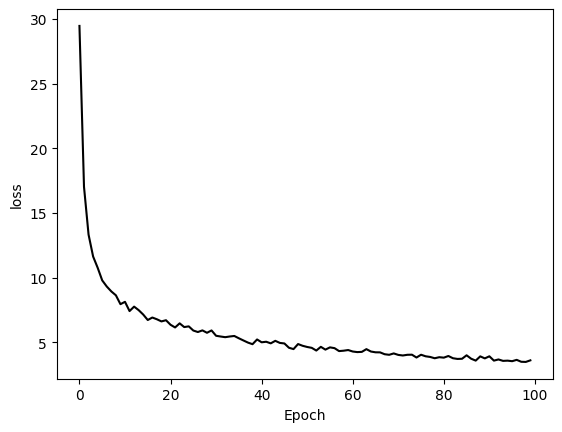

In [7]:
# Make a dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, size):
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        x = torch.tensor(X[index]).float().to(DEVICE)
        return x.view(1, -1) # add the channel

dataset = Dataset(len(X))
checkpoints_directory = "score_xray_clusters_20230731_2"
model = NCSNpp(channels=1, dimensions=1, nf=64, ch_mult=(2, 2)).to(DEVICE)
score_model = ScoreModel(model, sigma_min=1e-3, sigma_max=200)

losses = score_model.fit(
    dataset, 
    checkpoints_directory=checkpoints_directory, 
    epochs=100,
    batch_size=32, 
    learning_rate=1e-3,
    checkpoints=3,
    models_to_keep=3,
    ema_decay=0.99,
    max_time=1
)

plt.plot(losses, "-k")
plt.ylabel("Loss")
plt.xlabel("Epoch")

# Sampling from the prior

In [ ]:
# # Load the score model if checkpointing to avoid having to run the cell above the model
# checkpoints_directory = "score_xray_clusters_20230731_2"
# score_model = ScoreModel(checkpoints_directory=checkpoints_directory)

In [8]:
n = 100
em_steps = 200
samples = score_model.sample(n=100, shape=[1, 140], steps=em_steps)

100%|██████████| 200/200 [00:02<00:00, 78.58it/s]


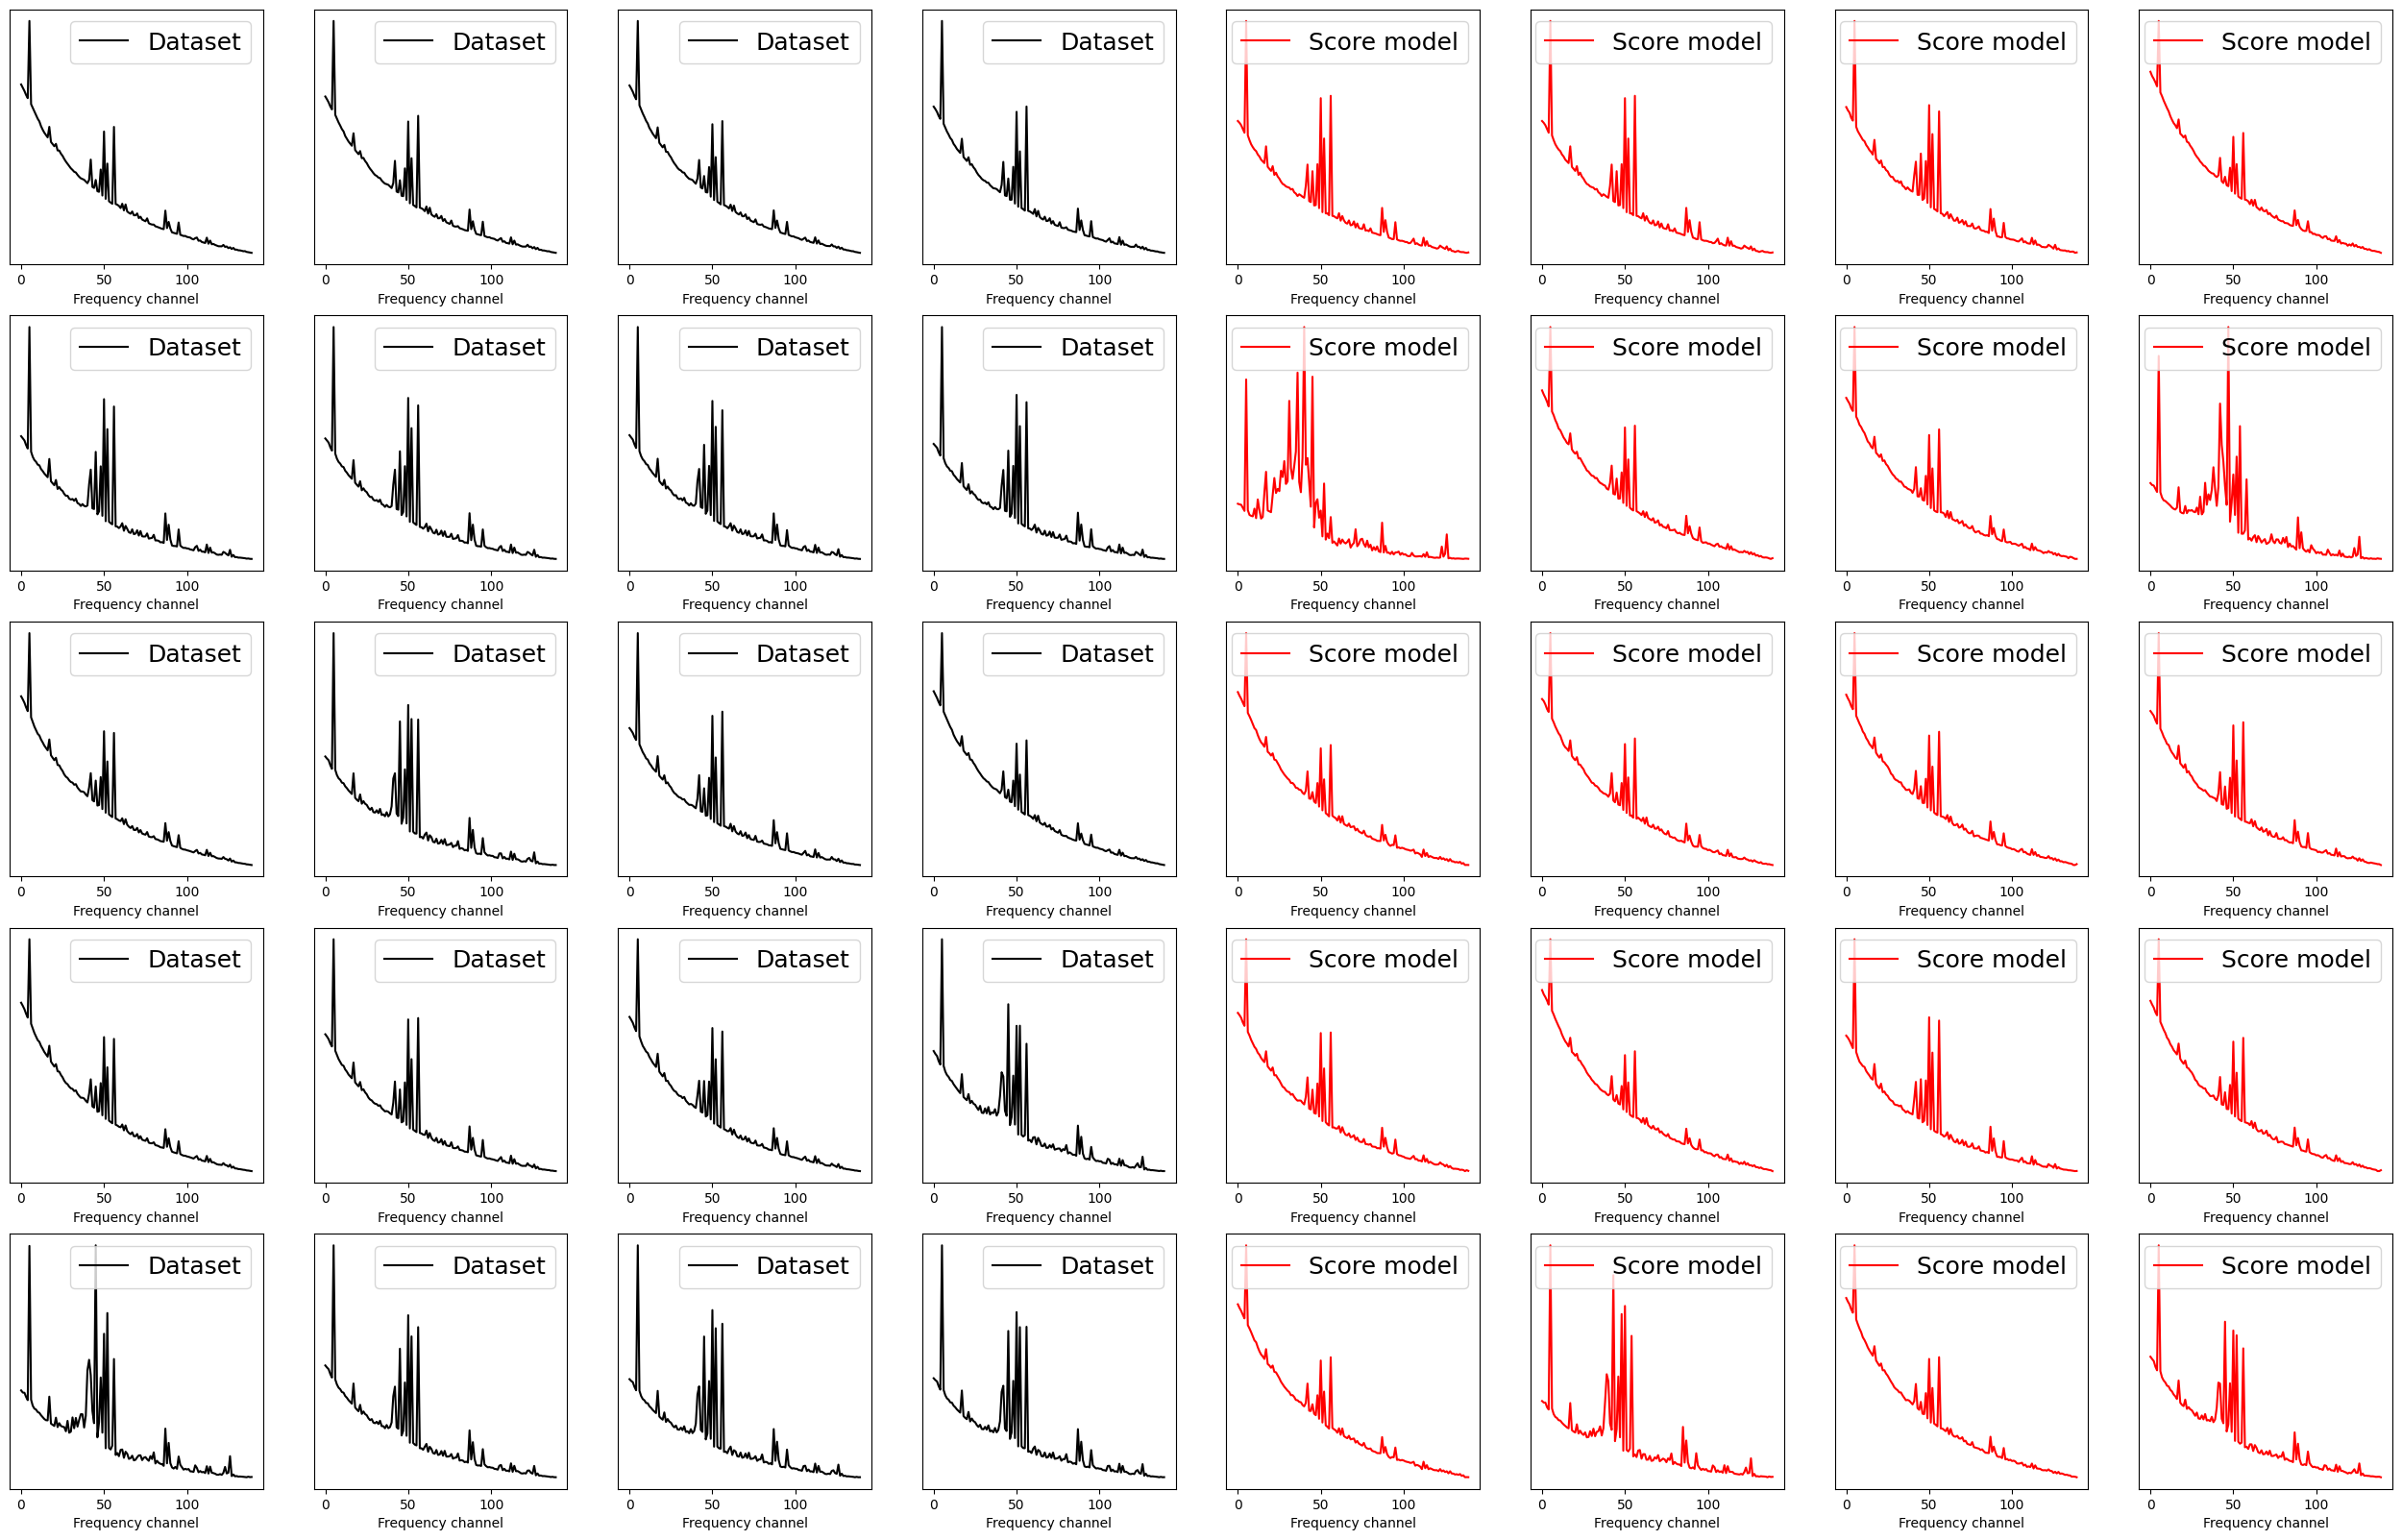

In [11]:
fig, axs = plt.subplots(5, 8, figsize=(32, 20))

for i in range(5):
    for j in range(4):
        k = np.random.randint(len(X))
        x = X[k]
        axs[i, j].plot(x, "-k", label="Dataset")
        axs[i, j].legend(fontsize=18)
        axs[i, j].set_xlabel("Frequency channel")
        axs[i, j].get_yaxis().set_visible(False)

        k = np.random.randint(n)
        x = samples[k].cpu().squeeze()
        axs[i, 4+j].plot(x, "-r", label="Score model")
        axs[i, 4+j].legend(fontsize=18)
        axs[i, 4+j].set_xlabel("Frequency channel")
        axs[i, 4+j].get_yaxis().set_visible(False)

# Sampling from the posterior

In [ ]:
# Load the score model if checkpointing to avoid having to retrain the model
checkpoints_directory = "score_xray_clusters_20230731_2"
score_model = ScoreModel(checkpoints_directory=checkpoints_directory)

In [ ]:
responses_data = pickle.load(open('RIM_clusters/rmfs_original.pkl', 'rb'))
A_dataset = np.stack([responses_data[val][min_:max_,min_:max_].T for val in responses_data]) # Need to use the tranpose of the dataset, saved in wrong order

In [ ]:
def likelihood_score_fn(t, x, y, A, sigma_n): # make sure to respect this signature (x, y, *args)
    """
    Annealed likelihood with the SDE of the diffusion model. 
    
    Naturally, this function has dimensions problems and will need to be vmapped over in the appropriate 
    way later. Notice the covariance which includes the for A @ A.T * sigma(t) factor. This factors 
    accounts for that noise that is introduced during the diffusion in the model space.
    
    Derivation of this term e.g. in Adam et al. (2022) https://arxiv.org/abs/2211.03812 Appendix A
    """
    precision = (sigma_n**2 + A @ A.T * score_model.sde.sigma(t)**2).inverse()
    y_pred = A @ x.squeeze() # remove channel dimension of x.
    score = - (y - y_pred) @ precision @ (-A)
    return score.unsqueeze(0) # give score back its channel dimensions

In [ ]:
# sample a response matrix
k = np.random.randint(len(A_dataset))
A = A_dataset[k]

# Pick a ground truth
k = np.random.randint(len(X))
x_true = X[k]

# Pick an SNR
snr = 10
sigma_n = x_true.max() / snr

# Make the observation
y = A @ x_true
y += np.random.randn(*y.shape) * sigma_n

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title("Ground Truth")
ax1.plot(x_true, "-k")
ax1.set_xlabel("Frequency channel")
ax1.set_ylabel("Intensity")

ax2.set_title("Observation")
ax2.plot(y, "-k")
ax2.set_xlabel("Frequency channel")
ax2.set_ylabel("Intensity")

In [35]:
# Send A and observation to tensor
A_tensor = torch.tensor(A).float().to(DEVICE)
y_tensor = torch.tensor(y).float().to(DEVICE)
# Wrap our likelihood score function to have correct signature for diffusion. Use vmap to deal with batch size
score_fn = vmap(lambda t, x: likelihood_score_fn(t, x, y_tensor, A_tensor, sigma_n))

# Quick test that our setup indeed works
t = torch.rand([10]).to(DEVICE)
x = torch.randn([10, 1, 140]).to(DEVICE)
score_fn(t, x).shape

torch.Size([]) torch.Size([1, 140])


torch.Size([10, 1, 140])

In [ ]:
# Now use score_fn with score_models sampling function introduced in version 0.4.7
n = 100 # number of posterior samples to draw
shape = [1, 140]
em_steps = 500 # use more steps for posterior sampling
guidance_factor = 1 # multiplicative factor for the likelihood. Use 1 for posterior sampling. 
posterior_samples = score_model.sample(n, shape, em_steps, score_fn, guidance_factor)